**Computer Vision - CS7GV1**

**Assignment 2**

**Name: Swetha Sekar**

**Student ID: 25336453**

### Import Libraries


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

##Q1 Describe the differences you observe in the left and right images

* **im01.png, im1.png** -The left and right images illustrate a real world 3D scene consisting of a plant pot placed at the front, a geographical map at the background (australia in focus), and few board pins and threads on the map.
* **chair0.png, chair1.png** - Here the images represent a 3D scene consisting of a chair, books, a scraf and rout maps in the background
* Both the stereo image pairs capture the same scene but are horizontally shifted, i.e, the objects in right image are shifted to the left when compared to the left image.
* In the both the scenarios, The objects at the front are shifted more than the object at the back
* This intuitively indicates the position of the objects in the 3D real world

##Q2 Write a function to calculate depth using SIFT at corner and edges.

In [3]:
def display_images(left_image, right_image):
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1), plt.imshow(left_image, cmap='gray'), plt.title("Left Image")
  plt.subplot(1, 2, 2), plt.imshow(right_image, cmap='gray'), plt.title("Right Image")
  plt.show()

In [4]:
def depth_map_at_corner_and_edges(left_image, right_image, focal_length, baseline, ratio_test_threshold=0.75, y_tolerance=2):

    g_left = cv2.cvtColor(left_image, cv2.COLOR_BGR2GRAY) if left_image.ndim == 3 else left_image.copy()
    g_right = cv2.cvtColor(right_image, cv2.COLOR_BGR2GRAY) if right_image.ndim == 3 else right_image.copy()

    sift = cv2.SIFT_create()
    key_1, descr_1 = sift.detectAndCompute(g_left, None)
    key_2, descr_2 = sift.detectAndCompute(g_right, None)

    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    matches = bf.knnMatch(descr_1, descr_2, k=2)

    match_results = []
    pts_left = []
    pts_right = []

    for x,y in matches:
        if x.distance < ratio_test_threshold * y.distance:
            ptL = key_1[x.queryIdx].pt
            ptR = key_2[x.trainIdx].pt

            if abs(ptL[1] - ptR[1]) <= y_tolerance:
                match_results.append(x)
                pts_left.append(ptL)
                pts_right.append(ptR)

    pts_left = np.array(pts_left, dtype=np.float32)
    pts_right = np.array(pts_right, dtype=np.float32)

    h, w = g_left.shape
    depth_map = np.zeros((h, w), dtype=np.float32)

    for (xL, yL), (xR, yR) in zip(pts_left, pts_right):
        disparity = xL - xR
        if disparity > 0:
            Z = (focal_length * baseline) / disparity
            depth_map[int(round(yL)), int(round(xL))] = Z

    return depth_map


In [6]:
def display_depth_map(depth_map):
  plt.figure(figsize=(15, 10))
  plt.imshow(depth_map, cmap='jet')
  plt.colorbar(label="Depth")
  plt.title("Depth map at corner and edges")
  plt.show()


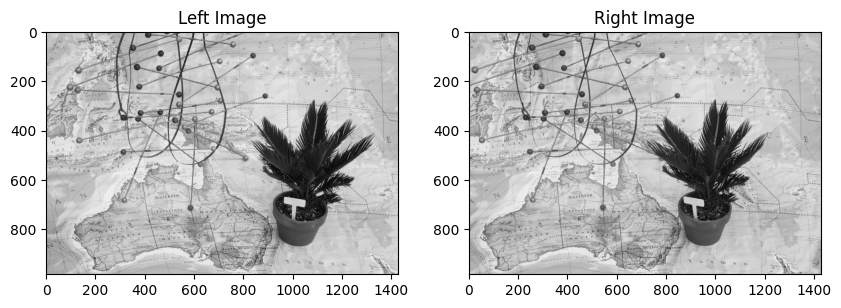

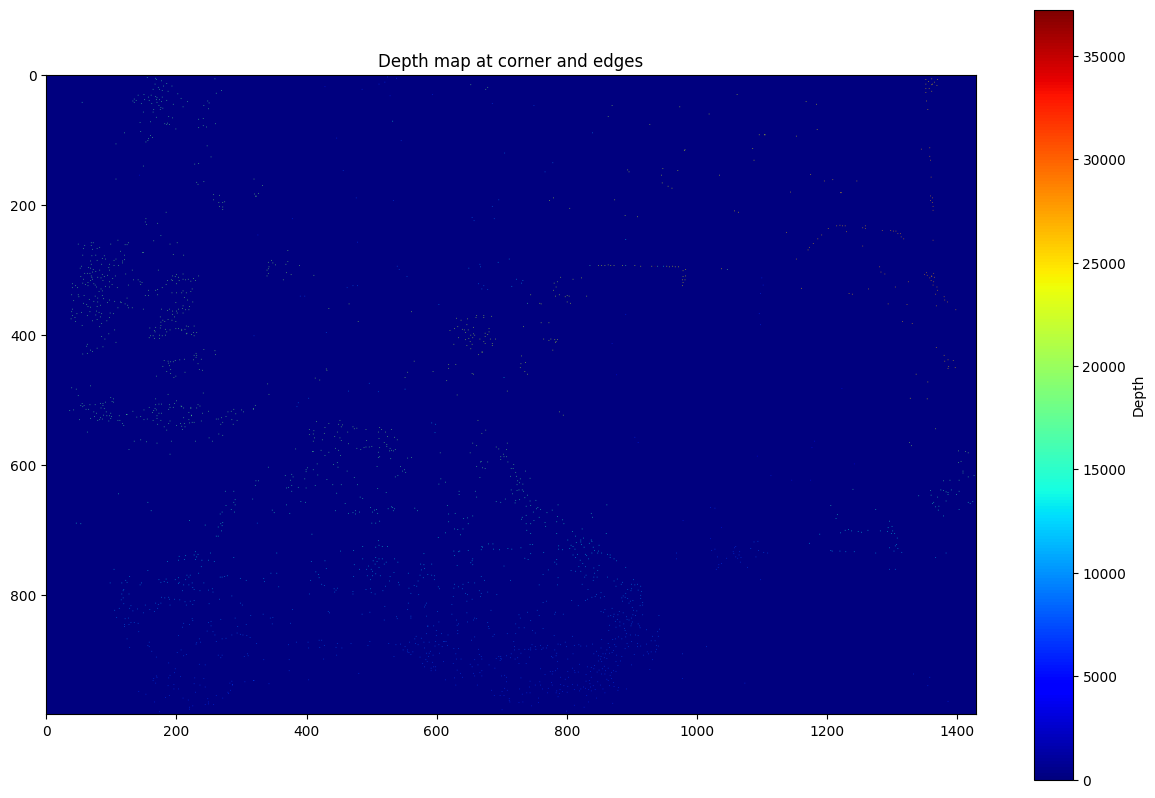

In [7]:
# Stereo image pair: im0.png, im1.png
left_image_im = cv2.imread('im0.png', cv2.IMREAD_GRAYSCALE)
right_image_im = cv2.imread('im1.png', cv2.IMREAD_GRAYSCALE)

if left_image_im is None or right_image_im is None:
    raise ValueError("Images not found! Make sure 'left_image.jpg' and 'right_image.jpg' are in the same directory.")

display_images(left_image_im, right_image_im)
depth_map_im = depth_map_at_corner_and_edges(left_image_im, right_image_im, focal_length = 2259.366, baseline = 258.3)
display_depth_map(depth_map_im)

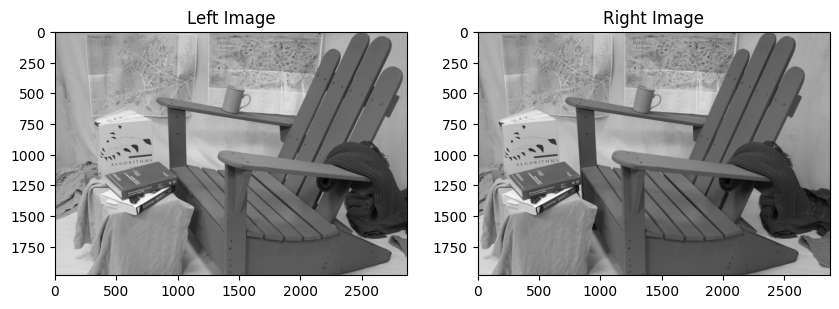

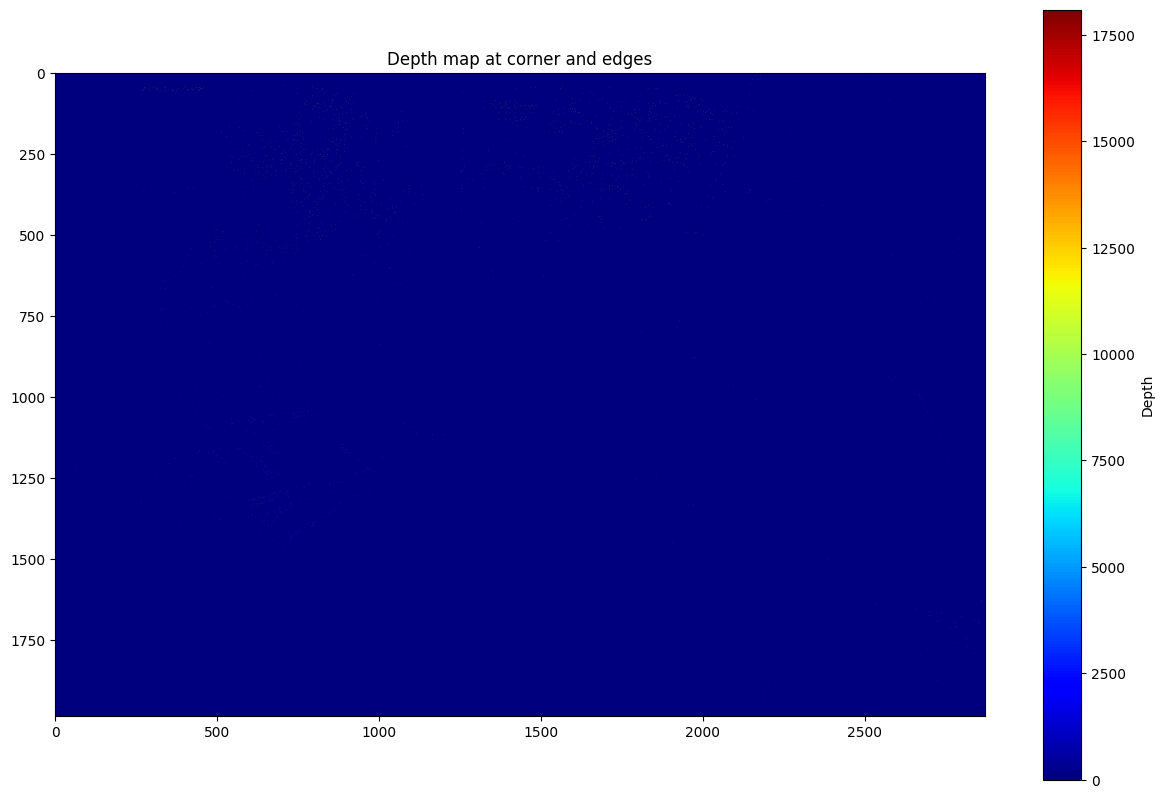

In [9]:
# Stereo image pair: chair0.png, chair1.png
left_image_chair = cv2.imread('chair0.png', cv2.IMREAD_GRAYSCALE)
right_image_chair = cv2.imread('chair1.png', cv2.IMREAD_GRAYSCALE)

if left_image_chair is None or right_image_chair is None:
    raise ValueError("Images not found! Make sure 'left_image.jpg' and 'right_image.jpg' are in the same directory.")

display_images(left_image_chair, right_image_chair)
depth_map_chair = depth_map_at_corner_and_edges(left_image_chair, right_image_chair, focal_length = 4152.073, baseline = 176.252)
display_depth_map(depth_map_chair)

##Q3 Write a function to calculate depth using patch matching at uniform region.

In [123]:
def depth_map_at_uniform_region(left_image, right_image, focal_length, baseline, ndisp, block_size=15, stride=5):
  g_left = cv2.cvtColor(left_image, cv2.COLOR_BGR2GRAY) if left_image.ndim == 3 else left_image.copy()
  g_right = cv2.cvtColor(right_image, cv2.COLOR_BGR2GRAY) if right_image.ndim == 3 else right_image.copy()

  h, w = g_left.shape
  depth_map = np.zeros((h, w), dtype=np.float32)
  mid = block_size // 2

  for i in range(mid, h - mid, stride):
    for j in range(mid, w - mid, stride):
      left_patch = g_left[i - mid : i + mid + 1, j - mid : j + mid + 1]

      best_disp = 0
      min_ssd = float('inf')
      for disp in range(0, min(ndisp, j - mid)):
        right_patch = g_right[i - mid : i + mid + 1, j - mid - disp : j + mid + 1 - disp]

        ssd = np.sum((left_patch.astype(float) - right_patch.astype(float))**2) #Sum of Squared Differences

        if ssd < min_ssd:
          min_ssd = ssd
          best_disp = disp

      if best_disp > 0:
        Z = (focal_length * baseline) / best_disp
        depth_map[i, j] = Z

  mask = (depth_map > 0).astype(np.uint8)
  if np.sum(mask) > 0:
      depth_map_masked = cv2.inpaint(depth_map.astype(np.float32), (1 - mask).astype(np.uint8), inpaintRadius=3, flags=cv2.INPAINT_NS)
      return depth_map_masked
  else:
      return depth_map

In [125]:
def display_depth_map_uniform(depth_map):
  plt.figure(figsize=(10, 5))
  depth_map[np.isinf(depth_map)] = 0
  depth_map[np.isnan(depth_map)] = 0
  depth_map[depth_map < 0] = 0
  vmin, vmax = np.percentile(depth_map, [5, 95])
  plt.imshow(depth_map, cmap='plasma', vmin=vmin, vmax=vmax)
  plt.colorbar(label='depth')
  plt.title("Depth map at uniform regions")
  plt.tight_layout()
  plt.show()

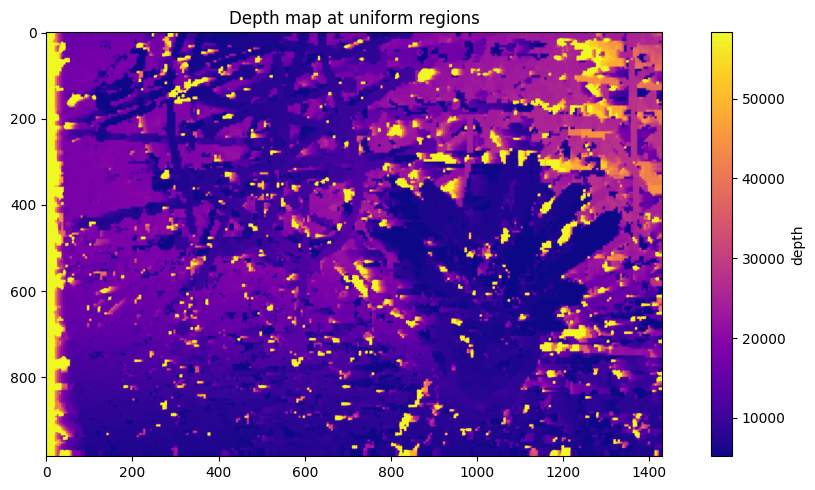

In [120]:
# Stereo image pair: im0.png, im1.png
depth_map_im_uniform = depth_map_at_uniform_region(left_image_im, right_image_im, focal_length = 2259.366, baseline = 258.3, ndisp = 145)
display_depth_map_uniform(depth_map_im_uniform)

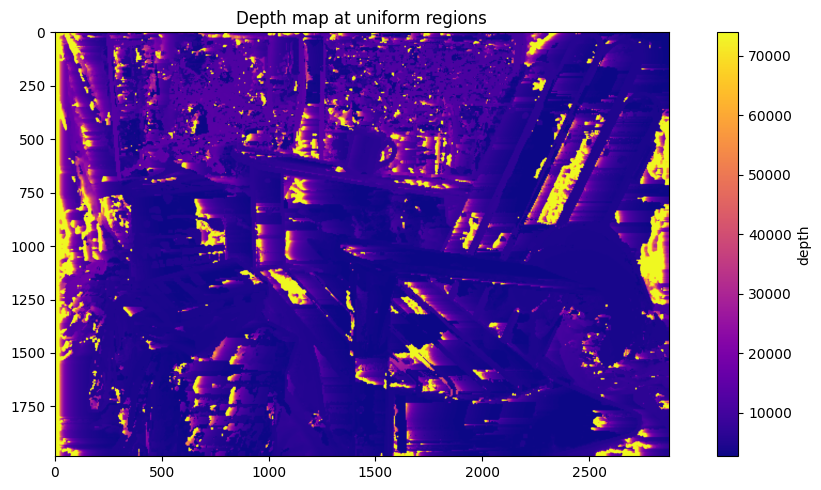

In [124]:
# Stereo image pair: chair0.png, chair1.png
depth_map_chair_uniform = depth_map_at_uniform_region(left_image_chair, right_image_chair, focal_length = 4152.073, baseline = 176.252, ndisp = 290)
display_depth_map_uniform(depth_map_chair_uniform)

##Q5 What does the disparity map represent? How does it relate to depth perception? Write the Mathematical Relationship

* Disparity map represents how much the keypoint in im0 and im1 have shifted horizontally.
* Different objects in the 3D world produce different horizontal keypoint shifts. For eg, the plat pot has more disparity compared to the background map.
* This emphasizes that farthest object shifts less and closest objects shift more. Thus, depth of the objects are encoded by disparity map
* Since the camera centre and the principal point of both images are parallel, there is no vertical shift.
* The relationship between depth and disparity is mathematically given as **Z = (f*b)/d** where Z -> dept, f -> focal length, b -> baseline, d = |xl - xr| -> disparity
This formula proves that depth and disparity are inversely proportional to each other (Z ∝ 1/d)

With the values from the calib txt file:
* **im0.png, im1.png** :
Z = (2259.366 * 258.3)/d

* **chair0.png, chair1.png** :
Z = (4152.073 * 176.252)/d



